In [1]:
#Request API key from Tiingo.Import Tiingo modules and configure API key
import tiingo
from tiingo import TiingoClient
from urllib.error import HTTPError
from tiingo.restclient import (RestClient, RestClientError)
from stockstats import StockDataFrame
config = {}
config['session'] = True
config['api_key'] = "15de2606da16a6f16273d8ebf1c3aef0fe28dfc6"
client = TiingoClient(config)
sort=True #This prevents a message from popping up that asks you set the default for a sorting function

#Import modules (not all of these are necessary)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime, timedelta
from decimal import *
import ast, math, calendar, time

#Enable displaying full range for dataframes
import logging, sys
logging.disable(sys.maxsize)
#logging.disable(logging.NOTSET) #uncomment to return to deafult. Only a portion of the beginning and end of dataframes will be displayed.

date = (datetime.now().strftime('%m-%d-%Y')) #Set a variable for the date that corresponds to the stock market data

In [2]:
#Function to use Tiingo API to get stock market price change for each stock in list obtained using webscrapper
def Tiingo(date=date,edition=''): 
    #upload list of 100 stocks (my default is saved to downloads). CSV files will automatically be named with the date and a tag (edition) for multiple downloads (e.g., (1), (2), etc.)
    rangers = pd.read_csv(r'C:\Users\USER\Downloads\all-us-exchanges-range-change-advances-%s%s.csv' %  (date,edition)).iloc[0:-1,0].to_list()   
    
    #Variables for Tiingo API request
    freq = '1min' #Time interval for data (e.g. 1min, 10min, etc.)
    strt=date; end=date #Days for downloading data. Note: tiingo only allows 1 date when requesting data for multiple stocks. You can only request multiple dates for a single stock
    
    #Create global variables to be used outside of function
    global stocks, data
    stocks = rangers     
    
    #Make sure Tiingo API request won't result in an error
    proof = False
    while proof == False:
        try:
            check_error(date=date)
        except KeyError:
                if Err_type1==True:
                    print('Key ERR type1')
                    rem_error(n=0)
                else:
                    print('Key ERR type2')
                    rem_error(n=err)
        except HTTPError:
                print('HTTP ERR')
                rem_error(n=err)
        except RestClientError:
                print('Client ERR')
                rem_error(n=err)        
        else:
            proof = True

        #Request stock market data from a list that contains no errors
        data = client.get_dataframe(stocks,
                                          frequency=freq,
                                          metric_name='close',
                                          startDate=strt,
                                          endDate=end)
    
    print('succesfully downloaded Tiingo')
    #I save the stock market data to a OneDrive folder
    data.to_csv(r'C:\Users\USER\OneDrive\QT-1\QT-1_Excel_data-set\QT-1.2 exports\QT1-1.7_Tiingo\tiingo_%s%s.csv' % (date,edition), index=False)

#################################################################
#Functions to check if stock is retrieved from Tiingo API when a "Date" error occurs when using the Tiingo Function :
#Part A: Find erroneous stock
def check_error(date):
    global Err_type1
    Err_type1=True
    for x in list(range(len(stocks))):
        stock = stocks[x]
        freq = '1min'
        strt=date; end=date

        data_check_error = client.get_dataframe(stock,
                                              frequency=freq,
                                              metric_name='close',
                                              startDate=strt,
                                              endDate=end)
        global err
        err=(x+1)
        Err_type1=False

#Part B: Remove erroneous stock
def rem_error(n=0):
    if Err_type1==True:
        print('rem_error starting without global err, n=0')
        pass
    else:
        print('rem_error starting with GLOBAL ERR=', err, 'and n=',n)
        pass
    stocks.pop(n)
    
#################################################################
#Function for extracting features from each stocks change in price. Named "species" for features used in a genetic algorithm. I've found that a few features can be used to more simply filter the data set for stocks that end up performing well
#This function is similar to "Perform Function" except is used during the day to 'predict' which stocks will continue to perform well based on filtering the current price changes
def Species(date=date,edition=''):
    data = pd.read_csv(r'C:\Users\USER\OneDrive\QT-1\QT-1_Excel_data-set\QT-1.2 exports\QT1-1.7_Tiingo\tiingo_%s%s.csv' % (date,edition)) #upload data from saved folder
    
    #This function is optimized for data obtained at 11AM EST but can be tested for other timepoints
    rate_sp=[];fin_rate=[];mean_rate=[];min_rate=[];max_rate=[]
    rate_pre=[];fin_rate_pre=[];mean_rate_pre=[];min_rate_pre=[];max_rate_pre=[]
    species_int = (60,90)

    #loop through stocks
    for n in list(range(data.shape[1])):
        data_list = data.values[:,n] # 0 is first element in df data
        
        #Initilize lists and variables for cumulative data
        cum_rate=[]; cum_rate_spi=[]; cum=0; cum_sp=0
        cum_pre=0; cum_rate_pre=[]

        #rate change from start to end (for graphing data)
        for n in list(range(data.shape[0] -1)):
            rate_i=( 100* ((data_list[n+1])-(data_list[n])) /(data_list[n])) # 100* (close-prev_close) / prev_close
            ######################################
            if math.isnan(rate_i) == True:
                rate_i=0
            ######################################    
            cum+=rate_i
            cum_rate.append(cum)  

        ###################################################
        
        #rate change during interval preceeding download (for features)
        for n in list(range(species_int[1]-species_int[0])):
            rate_spi=( 100* ((data_list[n+1+species_int[0]])-(data_list[n+species_int[0]])) /(data_list[n+species_int[0]]))
            if math.isnan(rate_spi) == False:
                cum_sp+=rate_spi
            cum_rate_spi.append(cum_sp)

        fin_rate.append(cum_sp)
        mean_rate.append(np.mean(list(filter(lambda num: num != 0, cum_rate_spi)))) #calculate rate for species
        min_rate.append(np.min(cum_rate_spi))
        max_rate.append(np.max(cum_rate_spi))

        #####################################################
        
        #rate change during total time preceeding download (for features)
        for n in list(range(species_int[0])):
            rate_pre=( 100* ((data_list[n+1])-(data_list[n])) /(data_list[n]))
            if math.isnan(rate_pre) == False:
                cum_pre+=rate_pre
            cum_rate_pre.append(cum_pre)

        fin_rate_pre.append(cum_pre)
        mean_rate_pre.append(np.mean(list(filter(lambda num: num != 0, cum_rate_pre)))) #calculate rate for species
        min_rate_pre.append(np.min(cum_rate_pre))
        max_rate_pre.append(np.max(cum_rate_pre))

        #Graphing data
        plt.plot(cum_rate)#, label=keys_df[n])
    plt.title('Cumulative Rate for All Species')
    plt.ylabel('% change in closing price')
    plt.xlabel('Time (min)')
    plt.axvline(x=species_int[0], c='g', linestyle='--');plt.axvline(x=species_int[1], c='g', linestyle='-');
    plt.show()

    #Stocks and species parameters
    keys_df=pd.DataFrame({'Stocks' : pd.DataFrame(data).keys()})
    fin_rate_df=pd.DataFrame({'FinalRate' : fin_rate})
    mean_rate_df=pd.DataFrame({'MeanRate' : mean_rate})
    min_rate_df=pd.DataFrame({'MinRate' : min_rate})
    max_rate_df=pd.DataFrame({'MaxRate' : max_rate})

    #Pre-species parameters
    fin_pre_df=pd.DataFrame({'FinPre' : fin_rate_pre})
    mean_pre_df=pd.DataFrame({'MeanPre' : mean_rate_pre})
    min_pre_df=pd.DataFrame({'MinPre' : min_rate_pre})
    max_pre_df=pd.DataFrame({'MaxPre' : max_rate_pre})
    #############################################
    DTE=[] #Dataframe for species' date
    for n in list(range(data.shape[0]+1)):
        DTE.append(date)
    DTE = pd.DataFrame({'Date' : DTE})

    #Organize data into dataframe and export to specified folder
    species=pd.concat([DTE, keys_df,fin_rate_df,mean_rate_df,min_rate_df,max_rate_df,fin_pre_df,mean_pre_df,min_pre_df,max_pre_df], axis=1, join='inner')
    species=species.sort_values(by=['FinalRate'], ascending=False) #sort by greatest final rate change
    species.to_csv(r'C:\Users\USER\OneDrive\QT-1\QT-1_Excel_data-set\QT-1.2 exports\QT1-1.7_TopSpecies\TopSpecies_%s%s.csv' % (date,edition), index=False)

    #################################################################
    
    #Generate a second graph only showing the top 3 stocks with highest range change
    N_top=3
    top_sp=species.iloc[0:N_top]['Stocks'].to_list()
    top=data[top_sp]

    #Similar to above
    for N in list(range(top.shape[1])):
        cum_rate=[]; cum_rate_spi=[]; cum=0; cum_sp=0
        data_list = top.values[:,N]
        for n in list(range(top.shape[0] -1)):
            rate_i=( 100* ((data_list[n+1])-(data_list[n])) /(data_list[n])) # 100* (close-prev_close) / prev_close
            if math.isnan(rate_i) == True:
                rate_i=0
            cum+=rate_i; cum_rate.append(cum) 
        plt.plot(cum_rate, label=top_sp[N])
    plt.title('Cumulative Rate for Top Species'); plt.ylabel('% change in closing price'); plt.xlabel('Time (min)')
    plt.axvline(x=species_int[0], c='g', linestyle='--');plt.axvline(x=species_int[1], c='g', linestyle='-');
    plt.legend(loc="upper left"); plt.show()
    display(species.head())
    #################################################################
#Function for filtering data for stocks 'predicted' to perform well during day
def Top(date=date,edition=''):
    species = pd.read_csv(r'C:\Users\USER\OneDrive\QT-1\QT-1_Excel_data-set\QT-1.2 exports\QT1-1.7_TopSpecies\TopSpecies_%s%s.csv' % (date,edition))
    top = pd.read_csv(r'C:\Users\USER\OneDrive\QT-1\QT-1_Excel_data-set\QT-1.2 exports\QT1-1.7_TopSpecies\TopSpecies_initial.csv')
                          
    top_n = 1; added = 0
    spec = species.values.tolist()
    for n in list(range(50)):
        if added == top_n:
            break
        if spec[n][5]-spec[n][2] <= 2 and spec[n][7] <= -2.5 and spec[n][8] <= -2.5 and spec[n][7] >= -10 and spec[n][2] >= 3:
            top = top.append(species[n:n+1])
            added+=1
    display(top)
    if top.shape[0] >= 0:
        top.to_csv(r'C:\Users\USER\OneDrive\QT-1\QT-1_Excel_data-set\QT-1.2 exports\QT1-1.7_Selections\Top_%s%s.csv' % (date,edition), index=False)
        
#Filters:
#1) MaxRate - FinRate <= 2%
#2) MeanPre is between -10% and -2.5%
#3) MinPre >= -2.5%
#4) FinRate >= 3%

C:\Users\USER\Anaconda3\lib\site-packages\tiingo\api.py:270: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  prices = pd.concat([prices, df[stock]], axis=1)


succesfully downloaded Tiingo


C:\Users\USER\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\USER\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


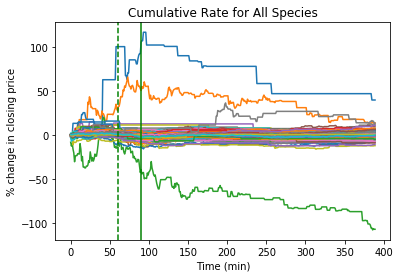

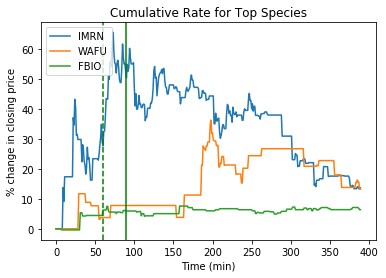

,Date,Stocks,FinalRate,MeanRate,MinRate,MaxRate,FinPre,MeanPre,MinPre,MaxPre
1,06-12-2020,IMRN,23.490926,21.898832,-1.304753,36.662971,28.936119,23.880473,0.000000,43.209716
187,06-12-2020,WAFU,4.020101,4.020101,0.000000,4.020101,3.749648,8.431735,0.000000,11.697723
76,06-12-2020,FBIO,1.490125,1.414038,0.584017,3.073730,4.444412,2.293429,-0.380228,5.344963
67,06-12-2020,TZOO,1.205840,0.865857,0.000000,1.205840,1.211346,0.925353,0.000000,1.211346
68,06-12-2020,OESX,0.848824,0.899787,0.847458,1.267234,-0.684744,0.505186,-0.701262,0.848650


,Date,Stocks,FinalRate,MeanRate,MinRate,MaxRate,FinPre,MeanPre,MinPre,MaxPre


In [3]:
Tiingo(date,edition =' (6)')
Species(date,edition =' (6)')
Top(date,edition =' (6)')

C:\Users\USER\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\USER\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


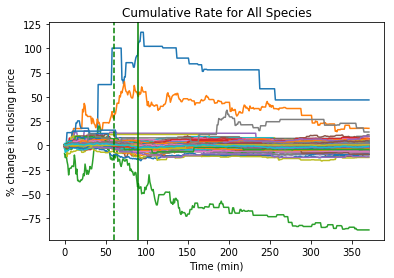

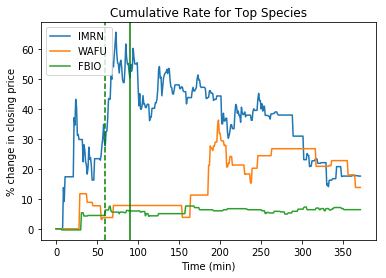

,Date,Stocks,FinalRate,MeanRate,MinRate,MaxRate,FinPre,MeanPre,MinPre,MaxPre
1,06-12-2020,IMRN,23.490926,21.898832,-1.304753,36.662971,28.936119,23.880473,0.000000,43.209716
187,06-12-2020,WAFU,4.020101,4.020101,0.000000,4.020101,3.749648,8.431735,0.000000,11.697723
76,06-12-2020,FBIO,1.490125,1.414038,0.584017,3.073730,4.444412,2.293429,-0.380228,5.344963
67,06-12-2020,TZOO,1.205840,0.865857,0.000000,1.205840,1.211346,0.925353,0.000000,1.211346
68,06-12-2020,OESX,0.848824,0.899787,0.847458,1.267234,-0.684744,0.505186,-0.701262,0.848650


In [11]:
Species(date,edition =' (6)')

In [14]:
Top(date,edition =' (6)')

,Date,Stocks,FinalRate,MeanRate,MinRate,MaxRate,FinPre,MeanPre,MinPre,MaxPre
